# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep = ';')


In [3]:
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep = ';')

In [4]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).

azdias.head()



,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [5]:
azdias.describe()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
count,891221.000000,891221.000000,891221.000000,886367.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,891221.000000,...,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,774706.000000,794005.000000,794005.000000,794005.00000
mean,-0.358435,2.777398,1.522098,3.632838,3.074528,2.821039,3.401106,3.033328,2.874167,3.075121,...,2.253330,2.801858,1.595426,0.699166,1.943913,3.612821,3.381087,3.167854,5.293002,3.07222
std,1.198724,1.068775,0.499512,1.595021,1.321055,1.464749,1.322134,1.529603,1.486731,1.353248,...,0.972008,0.920309,0.986736,0.727137,1.459654,0.973967,1.111598,1.002376,2.303739,1.36298
min,-1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,1.00000
25%,-1.000000,2.000000,1.000000,2.000000,2.000000,1.000000,3.000000,2.000000,2.000000,2.000000,...,1.000000,2.000000,1.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,2.00000
50%,-1.000000,3.000000,2.000000,4.000000,3.000000,3.000000,3.000000,3.000000,3.000000,3.000000,...,2.000000,3.000000,2.000000,1.000000,1.000000,4.000000,3.000000,3.000000,5.000000,3.00000
75%,-1.000000,4.000000,2.000000,5.000000,4.000000,4.000000,5.000000,5.000000,4.000000,4.000000,...,3.000000,3.000000,2.000000,1.000000,3.000000,4.000000,4.000000,4.000000,7.000000,4.00000
max,3.000000,9.000000,2.000000,6.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,4.000000,4.000000,3.000000,2.000000,5.000000,5.000000,5.000000,9.000000,9.000000,9.00000


In [6]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

In [7]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [8]:
feat_info.describe()

,attribute,information_level,type,missing_or_unknown
count,85,85,85,85
unique,85,9,5,9
top,SEMIO_SOZ,person,ordinal,[-1]
freq,1,43,49,26


In [9]:
feat_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 4 columns):
attribute             85 non-null object
information_level     85 non-null object
type                  85 non-null object
missing_or_unknown    85 non-null object
dtypes: object(4)
memory usage: 2.7+ KB


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [10]:
# Identify missing or unknown data values and convert them to NaNs.
# First let's look at how many values are 'naturally' missing

print('The number of values that are naturally missing in the demographic dataset is {}'.format(azdias.isnull().sum().sum()))


The number of values that are naturally missing in the demographic dataset is 4896838


In [11]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [12]:
# Now, lets identify missing or unknown values and convert them into NaNs

for col in range(azdias.shape[1]):
    col_name = azdias.columns[col]
    missing_or_unknown = feat_info.iloc[col,3]
    missing_or_unknown = missing_or_unknown.strip('[')
    missing_or_unknown = missing_or_unknown.strip (']')
    missing_or_unknown = missing_or_unknown.split(',')
    
    if missing_or_unknown == ['']:
        continue
    else:
        for val in missing_or_unknown:
            if azdias[col_name].dtype == 'object':
                azdias.loc[azdias[col_name] == val,col_name] = np.nan
            else:
                val = int(val)
                azdias.loc[azdias[col_name] == val,col_name] = np.nan

In [13]:
azdias.to_csv('azdias_na.csv')

In [14]:
print('The number of values that are still missing after the conversion is {}'.format(azdias.isnull().sum().sum()))

The number of values that are still missing after the conversion is 8373929


As can been seen above, before the conversion there were 4,896,838 number of missing values and after there were 8,373,929. Hence, further 3,5 million missing or unknown values have been identified and correctly labelled as NaN

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [15]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
#Let's look at how many missing values tehre are in each column

na_val = azdias.isnull().sum().sort_values(ascending= False)
print(na_val)

TITEL_KZ                 889061
AGER_TYP                 685843
KK_KUNDENTYP             584612
KBA05_BAUMAX             476524
GEBURTSJAHR              392318
ALTER_HH                 310267
REGIOTYP                 158064
KKK                      158064
W_KEIT_KIND_HH           147988
KBA05_ANTG4              133324
KBA05_GBZ                133324
MOBI_REGIO               133324
KBA05_ANTG1              133324
KBA05_ANTG2              133324
KBA05_ANTG3              133324
PLZ8_GBZ                 116515
PLZ8_HHZ                 116515
PLZ8_BAUMAX              116515
PLZ8_ANTG4               116515
PLZ8_ANTG1               116515
PLZ8_ANTG3               116515
PLZ8_ANTG2               116515
SHOPPER_TYP              111196
VERS_TYP                 111196
HEALTH_TYP               111196
NATIONALITAET_KZ         108315
PRAEGENDE_JUGENDJAHRE    108164
KBA13_ANZAHL_PKW         105800
ANZ_HAUSHALTE_AKTIV       99611
CAMEO_INTL_2015           99352
                          ...  
RETOURTY

In [16]:
na_val_p = na_val/(azdias.shape[0])*100

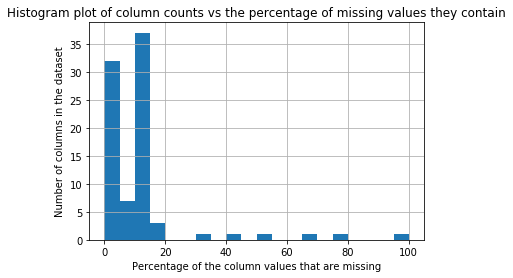

In [17]:
# Investigate patterns in the amount of missing data in each column.
plt.hist(na_val_p, bins=20, range = (0, 100))

plt.xlabel('Percentage of the column values that are missing')
plt.ylabel('Number of columns in the dataset')
plt.title('Histogram plot of column counts vs the percentage of missing values they contain')
plt.grid(True)
plt.show()

It can be seen above that most columns have under 20% of values being misssing and the rest of the columns are outliers. The columns with more than 20% missing values will be investigated but they are good candidates for being dropped from the dataset going forward

In [18]:
#Let's examine the outlier columns in terms of the missing values
more_than_20 = [col for col in azdias.columns if (azdias[col].isnull().sum()/azdias.shape[0])*100 > 20]
print(more_than_20)


['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


The above number of column names is as expected, histogram shows 6 instamces of columns containing more than 20% of missing values. Lets examine them further.


Looking up in the Data Dictionary
    AGER_TYP: Best-ager typology
    GEBURTSJAHR: Year of birth
    TITEL_KZ: Academic title flag
    ALTER_HH: Birthdate of head of household
    KK_KUNDENTYP: Consumer pattern over past 12 months
    KBA05_BAUMAX: Most common building type within the microcell
    
From the above explanations, I believe Year of birth and consumer pattern columns could be useful later even if they contain a lot of missing values. Let's see exactly how much missing data do both of these columns contain.

In [19]:
YOB = azdias['GEBURTSJAHR'].isnull().sum()/azdias.shape[0]*100
print('The Year of Birth column (GEBURTSJAHR) contains {}% missing values'.format(YOB))

The Year of Birth column (GEBURTSJAHR) contains 44.02028228688507% missing values


In [20]:
con_pat = azdias['KK_KUNDENTYP'].isnull().sum()/azdias.shape[0]*100
print('The Consumer pattern column (KK_KUNDENTYP) contains {}% missing values'.format(con_pat))

The Consumer pattern column (KK_KUNDENTYP) contains 65.59674873011295% missing values


44% and 65.6% for Year of birth and consumer pattern columns respectively seems to high of a propotion of missing values in a column to be used in analysis later. So all 6 columns which have more than 20% missing values will be removed from the dataset.


In [21]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

for col in more_than_20:
    azdias.drop(col,axis =1, inplace = True)

In [22]:
#Checking that the column removal worked as expected. 
#We had 85 columns to begin with and then we removed 6 columns identified, which should leave us with 79

azdias.shape[1]

79

#### Discussion 1.1.2: Assess Missing Data in Each Column

As mentioned above, most columns have less than 20% missing data with 6 outliers which contain more. Those columns were identified, with the potentially most useful ones singled out for further investigation, year of birth and consumer pattern. But these had too high levels of missing values. So all 6 columns have been removed from the dataset.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

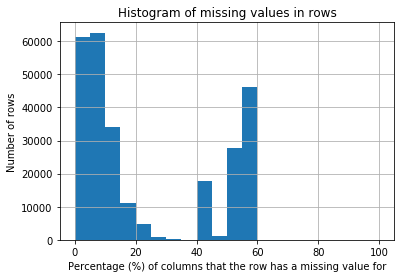

In [23]:
# How much data is missing in each row of the dataset?
row_missing = azdias.isnull().sum(axis = 1)
row_missing = row_missing[row_missing>0]/(len(azdias.columns))*100
row_missing.sort_values()

plt.hist(row_missing, bins=20, range = (0, 100))

plt.xlabel('Percentage (%) of columns that the row has a missing value for')
plt.ylabel('Number of rows')
plt.title('Histogram of missing values in rows')
plt.grid(True)

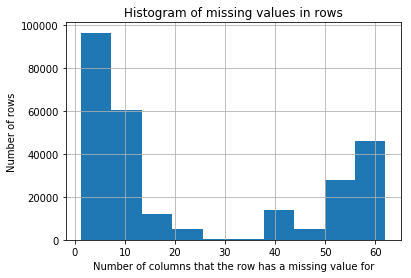

In [24]:
# I would also like to see the number of columns in absolute values
row_missing_v = row_missing[row_missing>0]
row_missing_v.sort_values()

plt.hist(row_missing_v, bins = 10)

plt.xlabel('Number of columns that the row has a missing value for')
plt.ylabel('Number of rows')
plt.title('Histogram of missing values in rows')
plt.grid(True)

In [25]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
#It is clear that the two sub-datasets can be separated by looking at the 40% (30 in absolute value) of missing data mark


low_missing = azdias[azdias.isnull().sum(axis =1) <30].reset_index(drop = True)
high_missing = azdias[azdias.isnull().sum(axis =1) >=30].reset_index(drop = True)


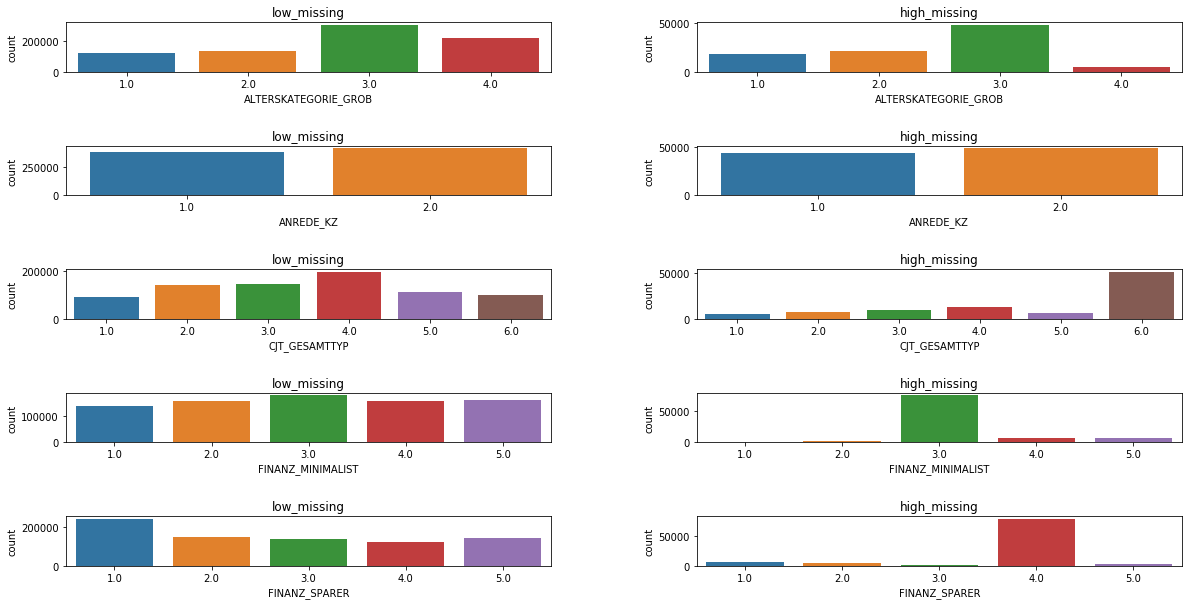

In [26]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.

low_col_names = low_missing.columns

def plot_print(col, n):
    
    fig, axs = plt.subplots(n, 2, figsize = (20,10))
    fig.subplots_adjust(hspace = 1.5, wspace = .3)
    axs = axs.ravel()
    
    for i in range (n):
        
        sns.countplot(low_missing[col[i]], ax = axs[i*2])
        axs[i*2].set_title('low_missing')
        
        sns.countplot(high_missing[col[i]], ax = axs[i*2+1])
        axs[i*2+1].set_title('high_missing')
        
plot_print(low_col_names,5)     

In [27]:
# 
print('The percentage of rows in the high_missing dataset, out of the whole dataset is {}%'.format((high_missing.shape[0]/azdias.shape[0])*100))

The percentage of rows in the high_missing dataset, out of the whole dataset is 10.4530750509694%


#### Discussion 1.1.3: Assess Missing Data in Each Row

The graphs above show the difference between the two datasets of low (less than 30 columns) missing values vs high (more than 30). The behaviour seems similar for the demographic features like gender and age brackets. However, the two datasets seem to behave differently for the financial variables. Also, lookng at the histograms the two datasets seems to be distincly split with no overlap. 

I would not be comfortable treating these two sub-sets as one dataset, seeing as their behavious differs significantly. Moreover, the high missing value dataset comprises 10,5% of the original number of columns and hence could be removed from the analysis without losing the 'scale' of the dataset. The high missing sunset of data shall be treated as 'special' and not included in the main analysis. 

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [28]:
# How many features are there of each data type?

features = list(low_missing.columns)
feat_info_c = feat_info[feat_info['attribute'].isin(features)]
data_type = feat_info_c['type'].value_counts()
for i in range(len(data_type)):
    print('There are {} {} features.'.format(data_type[i], data_type.index[i]))

There are 49 ordinal features.
There are 18 categorical features.
There are 6 numeric features.
There are 6 mixed features.


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [29]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_c[feat_info_c["type"]=="categorical"]["attribute"]


In [30]:
#I am going to separate the binary and the multi-level cateorical features, because they are going to be treated differently later on

binary = []
multi_level=[]
for feat in categorical:
    if (len(low_missing[feat].unique())==2):
        binary.append(feat)
    elif (len(low_missing[feat].unique())>2):
        multi_level.append(feat)
        
print('The list of the binary features in the dataset are {}'.format(binary))
print('The list of the multi-level features in the dataset are {}'.format(multi_level))

The list of the binary features in the dataset are ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
The list of the multi-level features in the dataset are ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [31]:
# I also want to see what the values are for the binary features to see if they are non-numeric and need to be encoded

for feat in binary:
    print('Values for {} are {}'.format(feat, low_missing[feat].unique()))

Values for ANREDE_KZ are [ 2.  1.]
Values for GREEN_AVANTGARDE are [0 1]
Values for SOHO_KZ are [ 1.  0.]
Values for OST_WEST_KZ are ['W' 'O']


In [32]:
# Re-encode categorical variable(s) to be kept in the analysis.
# From the cell above, it can be seen that values for OST_WEST_KZ feature take values W and O, 
#which need to be transposed to 0 ans 1 respectively to be used in further analysis

encode_val = {'W': 0, 'O':1}

azdias_ready = low_missing.replace({'OST_WEST_KZ': encode_val})

In [33]:
#Checking that the variable got updated:

for feat in binary:
    print('Values for {} are {}'.format(feat, azdias_ready[feat].unique()))

Values for ANREDE_KZ are [ 2.  1.]
Values for GREEN_AVANTGARDE are [0 1]
Values for SOHO_KZ are [ 1.  0.]
Values for OST_WEST_KZ are [0 1]


In [34]:
#Checking how many columns are multi-level categoricals:
len(multi_level)

14

In [35]:
# Dropping the multi-level categoricals (3 or more values)

for feat in multi_level:
    azdias_ready = azdias_ready.drop(feat, axis = 1)

In [36]:
# We had 79 columns in the dataset before the drop, so should have 65 columns remaining:

azdias_ready.shape[1]

65

#### Discussion 1.2.1: Re-Encode Categorical Features

I have first identified the types of features present in the dataset, honing down on categiricals, splitting them into binary (feature takes 2 values) or multi-level (feature takes 3 or more values). 

Amongst the binary features, there was one that took non numeric values, which I have chnaged to take values 0 and 1.

I have removed 14 columns of multi-level features.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [37]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

azdias_ready['MOVEMENT'] = azdias_ready['PRAEGENDE_JUGENDJAHRE']
azdias_ready['DECADE'] = azdias_ready['PRAEGENDE_JUGENDJAHRE']


In [38]:
# Now matching the value of PRAEGENDE_JUGENDJAHRE to the meaning in the dictionary
# For MOVEMENT: 1 is Mainstream, 0 is Avangarde
mov_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

# For DECADE: 1 is 40s, 2 is 50s, 3 is 60s, 4 is 70s, 5 is 80s, 6 is 90s
dec_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}


In [39]:
azdias_ready['MOVEMENT'].replace(mov_dict, inplace = True)
azdias_ready['DECADE'].replace(mov_dict, inplace = True)

In [40]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias_ready['WEALTH'] = azdias_ready['CAMEO_INTL_2015']
azdias_ready['LIFE_STAGE'] = azdias_ready['CAMEO_INTL_2015']

In [41]:
# Now matching the value of CAMEO_INTL_2015 to the meaning in the dictionary
# For WEALTH: 11-15 is 1, 21-25 is 2, 31-35 is 3, 41-45 is 4, 51-55 is 5
w_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
          '21':2, '22':2, '23':2, '24':2, '25':2,
          '31':3, '32':3, '33':3, '34':3, '35':3,
          '41':4, '42':4, '43':4, '44':4, '45':4,
          '51':5, '52':5, '53':5, '54':5, '55':5}

# For Life stage: (11,21,31,41,51) is 1, (12,22,32,42,52) is 2, (13,23,33,43,53) is 3, (14,24,34,44,54) is 4, (15,25,35,45,55) is 5
lf_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, 
           '21':1, '22':2, '23':3, '24':4, '25':5,
           '31':1, '32':2, '33':3, '34':4, '35':5,
           '41':1, '42':2, '43':3, '44':4, '45':5,
           '51':1, '52':2, '53':3, '54':4, '55':5}

In [42]:

azdias_ready['WEALTH'].replace (w_dict, inplace = True)
azdias_ready['LIFE_STAGE'].replace (lf_dict, inplace = True)

In [43]:
# We have added 4 new columns: MOVEMENT, DECADE, LIFE_STAGE, WEALTH to the existing 65, so we should have 69 columns:

azdias_ready.shape[1]

69

In [44]:
# Dropping the mixed- value features

azdias_ready = azdias_ready.drop(['PLZ8_BAUMAX',
                                  'WOHNLAGE',
                                  'LP_LEBENSPHASE_FEIN',
                                  'LP_LEBENSPHASE_GROB',
                                  'PRAEGENDE_JUGENDJAHRE',
                                  'CAMEO_INTL_2015'],
                                    axis = 1)


In [45]:
azdias_ready.shape[1]

63

#### Discussion 1.2.2: Engineer Mixed-Type Features
1. I have added two columns (MOVEMENT and DECADE) from the existing PRAEGENDE_JUGENDJAHRE
2. I have added two columns (WEALTH and LIFE_STAGE) from the existing CAMEO_INTL_2015

From the existing 6 mixed-value variables, 2 columns were extracted from each of the two features above. The rest 4 features have been decided to be dropped. 

(Double-click this cell and replace this text with your own text, reporting your findings and decisions regarding mixed-value features. Which ones did you keep, which did you drop, and what engineering steps did you perform?)

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [46]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

features = list(azdias_ready.columns)
feat_info_c = feat_info[feat_info['attribute'].isin(features)]
data_type = feat_info_c['type'].value_counts()
for i in range(len(data_type)):
    print('There are {} {} features.'.format(data_type[i], data_type.index[i]))

There are 49 ordinal features.
There are 6 numeric features.
There are 4 categorical features.


In [47]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.

azdias_ready.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,1.0,2.0,1.0,5.0,2.0,5.0,4.0,5.0,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,1.0,1.0,5.0,1.0
1,3.0,2.0,1.0,4.0,1.0,2.0,3.0,5.0,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,0.0,0.0,2.0,4.0
2,4.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,1.0,1.0,1.0,2.0
3,3.0,1.0,4.0,3.0,4.0,1.0,3.0,2.0,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,1.0,1.0,4.0,3.0
4,1.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,1.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [48]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...

    for indx in range(len(feat_info)):
        missing_or_unknown = feat_info.iloc[indx]['missing_or_unknown']
        missing_or_unknown = missing_or_unknown.strip('[')
        missing_or_unknown = missing_or_unknown.strip(']')
        missing_or_unknown = missing_or_unknown.split(sep=',')
        missing_or_unknown = [int(value) if (value!='X' and value!='XX' and value!='') else value for value in missing_or_unknown]
        if missing_or_unknown != ['']:
            df = df.replace({feat_info.iloc[indx]['attribute']: missing_or_unknown}, np.nan)
    
    # remove selected columns and rows, ...
    # Dropping the columns with more than 20% missing data which now includes :
    more_than_20 = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    
    for col in more_than_20:
        df.drop(col,axis =1, inplace = True)
    
    # Dropping rows with missing data in more than 30 columns
    df = df[df.isnull().sum(axis =1) < 30]
    
    # select, re-encode, and engineer column values.
    # re-encoding the binary feature with non-numeric values:
    encode_val = {'W': 0, 'O':1}
    df = df.replace({'OST_WEST_KZ': encode_val})
    
    # Dropping the multi-level categoricals (3 or more values)
    
    multi_level= ['CJT_GESAMTTYP', 
                  'FINANZTYP',
                  'GFK_URLAUBERTYP',
                  'LP_FAMILIE_FEIN', 
                  'LP_FAMILIE_GROB',
                  'LP_STATUS_FEIN',
                  'LP_STATUS_GROB',
                  'NATIONALITAET_KZ',
                  'SHOPPER_TYP',
                  'VERS_TYP',
                  'ZABEOTYP',
                  'GEBAEUDETYP',
                  'CAMEO_DEUG_2015',
                  'CAMEO_DEU_2015']

    for feat in multi_level:
        df = df.drop(feat, axis = 1)
        
    # Working with mixed variables:
    mov_dict = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    dec_dict = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    df['MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE']
    df['DECADE'] = df['PRAEGENDE_JUGENDJAHRE']
    df['MOVEMENT'].replace(mov_dict, inplace = True)
    df['DECADE'].replace(mov_dict, inplace = True)
    
    w_dict = {'11':1, '12':1, '13':1, '14':1, '15':1,
              '21':2, '22':2, '23':2, '24':2, '25':2,
              '31':3, '32':3, '33':3, '34':3, '35':3,
              '41':4, '42':4, '43':4, '44':4, '45':4,
              '51':5, '52':5, '53':5, '54':5, '55':5}

    lf_dict = {'11':1, '12':2, '13':3, '14':4, '15':5, 
               '21':1, '22':2, '23':3, '24':4, '25':5,
               '31':1, '32':2, '33':3, '34':4, '35':5,
               '41':1, '42':2, '43':3, '44':4, '45':5,
               '51':1, '52':2, '53':3, '54':4, '55':5}
    df['WEALTH'] = df['CAMEO_INTL_2015']
    df['LIFE_STAGE'] = df['CAMEO_INTL_2015']
    df['WEALTH'].replace (w_dict, inplace = True)
    df['LIFE_STAGE'].replace (lf_dict, inplace = True)
    
    df_ready = df.drop(['PLZ8_BAUMAX',
                      'WOHNLAGE',
                      'LP_LEBENSPHASE_FEIN',
                      'LP_LEBENSPHASE_GROB',
                      'PRAEGENDE_JUGENDJAHRE',
                      'CAMEO_INTL_2015'],
                        axis = 1)

    # Return the cleaned dataframe.
    return df_ready 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [49]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.

imputer = Imputer(strategy = 'most_frequent')
azdias_ready_imp = pd. DataFrame(imputer.fit_transform(azdias_ready), columns = azdias_ready.columns)



In [50]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_ready_scaled = pd.DataFrame(scaler.fit_transform(azdias_ready_imp), columns = azdias_ready_imp.columns)


In [51]:
azdias_ready_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,MOVEMENT,DECADE,WEALTH,LIFE_STAGE
0,-1.766646,0.957914,-1.494594,1.537924,-1.040692,1.465965,0.958645,1.339314,-0.530409,1.010164,...,0.442528,1.455847,0.574305,-0.171400,-0.127041,0.684882,0.530409,0.530409,1.175657,-1.248894
1,0.200522,0.957914,-1.494594,0.864563,-1.766980,-0.570998,0.244119,1.339314,1.885336,1.010164,...,-0.934798,0.419740,0.574305,-0.171400,-0.127041,-0.789027,-1.885336,-1.885336,-0.869680,0.767095
2,1.184106,0.957914,0.683144,-0.482158,1.138172,-0.570998,-1.184933,-0.791205,-0.530409,-0.311816,...,-0.934798,-0.616366,0.574305,-1.173149,-0.997549,-0.052072,0.530409,0.530409,-1.551459,-0.576897
3,0.200522,-1.043935,0.683144,0.191203,0.411884,-1.249985,0.244119,-0.791205,-0.530409,1.010164,...,0.442528,-0.616366,-0.337195,0.830348,0.308213,1.421837,0.530409,0.530409,0.493878,0.095099
4,-1.766646,0.957914,-0.042768,-1.155518,1.138172,-0.570998,-0.470407,1.339314,-0.530409,1.010164,...,0.442528,1.455847,1.485805,-1.173149,-0.997549,-0.052072,0.530409,0.530409,1.175657,0.767095


### Discussion 2.1: Apply Feature Scaling

I have replaced the missing values with the most frequent value for that feature, because I did not want 'mean' method used on binary variables.

Afterwards, I have scaled the dataset to have mean of 0 and standard deviation of 1

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
pca = PCA()
azdias_pca = pca.fit_transform(azdias_ready_scaled)


In [53]:
def scree_plot(pca):
    comp = len(pca.explained_variance_ratio_)
    ind = np.arange(comp)
    val = pca.explained_variance_ratio_
    
    plt.figure(figsize=(10,5))
    ax = plt.subplot(111)
    cum_val = np.cumsum(val)
    ax.bar(ind, val)
    ax.plot(ind, cum_val)
    
    plt.grid()
    plt.title('Variance accounteed for by each principal component')
    ax.set_xlabel('Explained Variance Ratio')
    ax.set_ylabel('Number of Principal Components')
    

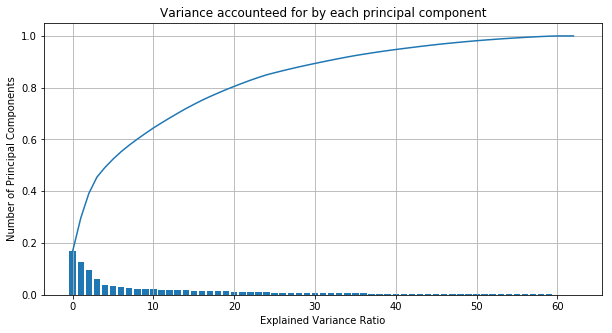

In [54]:
scree_plot(pca)

In [55]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca_num = PCA(n_components = 25)
azdias_pca_num = pca_num.fit_transform(azdias_ready_scaled)

In [56]:
pca_num.explained_variance_ratio_.sum()

0.84966687391322571

### Discussion 2.2: Perform Dimensionality Reduction

It was decided to retain 25 principal components seeing as they explain 85% of variance as seen on the graph above while eliminating more than half of the number of variables. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [57]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def weights_pca(pca, i):
    t = pd.DataFrame(pca.components_, columns = list(azdias_ready_scaled.columns))
    w = t.iloc[i].sort_values(ascending = False)
    return w



In [58]:
#Mapping the weights for the first principal component
weights1 = weights_pca(pca_num,0)
print(weights1)

PLZ8_ANTG3               0.230239
PLZ8_ANTG4               0.221904
WEALTH                   0.212263
HH_EINKOMMEN_SCORE       0.211668
ORTSGR_KLS9              0.198369
EWDICHTE                 0.196366
FINANZ_HAUSBAUER         0.171272
KBA05_ANTG4              0.159655
PLZ8_ANTG2               0.156522
ARBEIT                   0.146382
KBA05_ANTG3              0.141497
ANZ_HAUSHALTE_AKTIV      0.141206
RELAT_AB                 0.137765
FINANZ_SPARER            0.129466
MOVEMENT                 0.124832
DECADE                   0.124832
SEMIO_PFLICHT            0.100317
SEMIO_REL                0.096381
SEMIO_RAT                0.083363
SEMIO_TRADV              0.072714
SEMIO_MAT                0.069414
SEMIO_FAM                0.066141
REGIOTYP                 0.065075
SEMIO_KULT               0.057943
OST_WEST_KZ              0.057786
FINANZ_UNAUFFAELLIGER    0.057126
FINANZ_ANLEGER           0.056893
W_KEIT_KIND_HH           0.048444
SEMIO_KAEM               0.046365
KKK           

In [59]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights2 = weights_pca(pca_num,1)
print(weights2)

ALTERSKATEGORIE_GROB     0.271879
SEMIO_ERL                0.259342
FINANZ_VORSORGER         0.234921
SEMIO_LUST               0.189143
RETOURTYP_BK_S           0.157996
SEMIO_KRIT               0.141776
SEMIO_KAEM               0.141067
ANREDE_KZ                0.123088
FINANZ_HAUSBAUER         0.106687
W_KEIT_KIND_HH           0.103603
SEMIO_DOM                0.097998
EWDICHTE                 0.074747
ORTSGR_KLS9              0.073104
FINANZ_MINIMALIST        0.071951
PLZ8_ANTG3               0.071566
PLZ8_ANTG4               0.070410
WOHNDAUER_2008           0.063185
KBA05_ANTG4              0.057891
WEALTH                   0.055174
ARBEIT                   0.054166
RELAT_AB                 0.053050
ANZ_HAUSHALTE_AKTIV      0.050875
PLZ8_ANTG2               0.049734
HH_EINKOMMEN_SCORE       0.041367
KBA05_ANTG3              0.034599
ANZ_HH_TITEL             0.028071
OST_WEST_KZ              0.020433
LIFE_STAGE               0.012949
PLZ8_HHZ                 0.011012
DECADE        

In [60]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

weights3 = weights_pca(pca_num,2)
print(weights3)


SEMIO_VERT               0.337369
SEMIO_SOZ                0.250139
SEMIO_FAM                0.225310
SEMIO_KULT               0.205764
FINANZ_MINIMALIST        0.165735
RETOURTYP_BK_S           0.126162
FINANZ_VORSORGER         0.124758
ALTERSKATEGORIE_GROB     0.110653
W_KEIT_KIND_HH           0.092562
SEMIO_LUST               0.087513
GREEN_AVANTGARDE         0.067606
ORTSGR_KLS9              0.067126
EWDICHTE                 0.066591
PLZ8_ANTG4               0.059707
PLZ8_ANTG3               0.059402
ARBEIT                   0.045373
RELAT_AB                 0.043739
PLZ8_ANTG2               0.041177
WOHNDAUER_2008           0.040080
KBA05_ANTG4              0.035739
SEMIO_REL                0.035409
SEMIO_MAT                0.034245
WEALTH                   0.031639
ANZ_HAUSHALTE_AKTIV      0.031567
ANZ_HH_TITEL             0.018385
OST_WEST_KZ              0.015103
KBA05_ANTG3              0.012537
ANZ_TITEL                0.012368
PLZ8_HHZ                 0.010191
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

For the first principal components, we can deduce that:
- Number of large house (6-10 families) is positively correlated with the number of very large houses (10+ families) and negatively correlated with small houses (1-2 families) and number of buildings in a micro-cell which is to be expected

- The estimated age group is positively correlated with the kind of shopper and returner (how many purchsed items the person returns) feature and negatively correlated with the online affinity variable. Both shopping styles (with younger population more prone to buy and return) and online usage are generally thought of as correlated with age. So the relationships are as expected

For the second pricipal component, we can deduce that:
 - Estimated age bracket of teh individual is positively correlated with the number of children in the household, whch is to be expected as older people tend to have had more children
 - Estimated age bracket is negatively correlated to the internet affinity which is also to be expected because, in general, older people tend to use the internet less

For the third pricipal component, we can deduce that:
 -  The size of the community that the individual inhabits is positively correlated to the number of 6-10 and 10+ families per house variables. This is to be expected as large number of people populating the 6+ people families, creates a densely populated and hence large sized community.
 - It is interesting to see that unemployment rate in a community (ARBEIT) and density of households per square kilometer are positively correlated. I would not have picked that up as an obvious connection
 - However, it does make sense that the above mentioned density of households per square kilometer (EWDICHTE) is negatively correlated to the number of 1-2 family houses in the area (PLZ8_ANTG1). Because the more densely populated the area, the more houses with larger families you would expect to see. 


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [61]:
def get_kmeans_score(data, center):
    
    kmeans = KMeans (n_clusters = center)
    model = kmeans.fit(data)
    score = np. abs(model.score(data))
    
    return score

In [ ]:
# Over a number of different cluster counts...
scores = []
centers = list(range(2,30, 5))

    # run k-means clustering on the data and...
for center in centers:
    scores.append(get_kmeans_score(azdias_pca_num, center))
    
    # compute the average within-cluster distances.
    
    

Text(0,0.5,'Within-cluster distances')

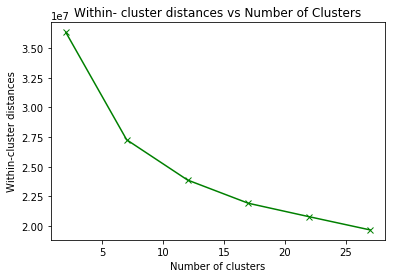

In [63]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

plt.plot(centers, scores, linestyle = '-', marker = 'x',color = 'g')
plt.title('Within- cluster distances vs Number of Clusters')
plt.xlabel('Number of clusters')
plt.ylabel('Within-cluster distances')

In [64]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(n_clusters = 12)
model_12 = kmeans.fit(azdias_pca_num)
model_pred = model_12.predict(azdias_pca_num)

### Discussion 3.1: Apply Clustering to General Population

After producing and examining the graph of within-cluster distances vs the number of clusters, we can see as expected a big drop with the increase of the number of clusres where the total number of clusters is less than 10. However after that the within-cluser distances dimish at a much slower rate. I have chosen to proceed with 12 clusters because it looks like 'an elbow' i.e. a breaking point in the rate of diminishing with-cluser distances.  

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [65]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')

In [66]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.

customers_clean = clean_data(customers)

In [67]:
# Replace the NaN values
customers_clean_imputed = pd.DataFrame(imputer.transform(customers_clean))
customers_clean_imputed.columns = customers_clean.columns
customers_clean_imputed.index = customers_clean.index

In [68]:
#normalization using StandardScaler
customers_clean_scaled = scaler.transform(customers_clean_imputed)


In [69]:
#transform the customers data using pca object
pca_customers_clean = pca.transform(customers_clean_imputed)

In [70]:
# PCA transformation
customers_pca = pca_num.transform(customers_clean_scaled)

In [71]:
customers_pred = model_12.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

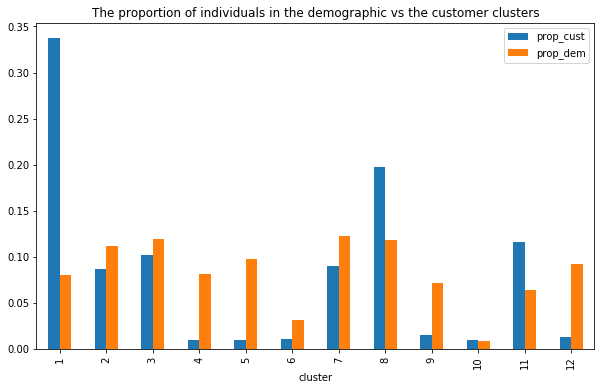

In [72]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.

cust_data = []
dem_data = []
x = [i+1 for i in range(12)]
for i in range(12):
    dem_data.append((model_pred == i).sum()/len(model_pred))
    cust_data.append((customers_pred == i).sum()/len(customers_pred))


df_prop = pd.DataFrame({'prop_cust':cust_data, 'prop_dem' : dem_data,'cluster' : x })

#ax = sns.countplot(x='index', y = df_general['prop_1', 'prop_2'], data=df_general )
df_prop.plot(x='cluster', y = ['prop_cust', 'prop_dem'], kind='bar', figsize=(10,6))

plt.title('The proportion of individuals in the demographic vs the customer clusters')
plt.show()



In [73]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster_1 = scaler.inverse_transform(pca_num.inverse_transform(model_12.cluster_centers_[1]))
over_cluster = pd.Series(data = cluster_1, index = customers_clean.columns)
print(over_cluster)

ALTERSKATEGORIE_GROB        3.481359
ANREDE_KZ                   1.920664
FINANZ_MINIMALIST           3.582889
FINANZ_SPARER               1.883693
FINANZ_VORSORGER            4.083831
FINANZ_ANLEGER              2.845550
FINANZ_UNAUFFAELLIGER       2.051897
FINANZ_HAUSBAUER            2.898675
GREEN_AVANTGARDE           -0.000864
HEALTH_TYP                  2.098604
RETOURTYP_BK_S              3.399354
SEMIO_SOZ                   2.547189
SEMIO_FAM                   2.128721
SEMIO_REL                   2.186629
SEMIO_MAT                   2.454217
SEMIO_VERT                  3.035960
SEMIO_LUST                  4.909954
SEMIO_ERL                   6.366810
SEMIO_KULT                  2.099858
SEMIO_RAT                   3.475692
SEMIO_KRIT                  5.775365
SEMIO_DOM                   5.503518
SEMIO_KAEM                  5.462528
SEMIO_PFLICHT               2.992351
SEMIO_TRADV                 2.679346
SOHO_KZ                    -0.000132
ANZ_PERSONEN                1.788247
A

In [74]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster_5 = scaler.inverse_transform(pca_num.inverse_transform(model_12.cluster_centers_[5]))
under_cluster = pd.Series(data = cluster_5, index = customers_clean.columns)
print(under_cluster)

ALTERSKATEGORIE_GROB        1.961068
ANREDE_KZ                   1.997275
FINANZ_MINIMALIST           2.891320
FINANZ_SPARER               3.724626
FINANZ_VORSORGER            2.360918
FINANZ_ANLEGER              3.820660
FINANZ_UNAUFFAELLIGER       4.013258
FINANZ_HAUSBAUER            2.138001
GREEN_AVANTGARDE            0.992507
HEALTH_TYP                  2.416396
RETOURTYP_BK_S              2.490282
SEMIO_SOZ                   3.075314
SEMIO_FAM                   3.336090
SEMIO_REL                   4.512818
SEMIO_MAT                   4.423499
SEMIO_VERT                  2.711228
SEMIO_LUST                  3.301903
SEMIO_ERL                   4.637254
SEMIO_KULT                  3.483289
SEMIO_RAT                   5.702921
SEMIO_KRIT                  5.577955
SEMIO_DOM                   6.419225
SEMIO_KAEM                  5.875540
SEMIO_PFLICHT               5.461895
SEMIO_TRADV                 5.247656
SOHO_KZ                     0.000076
ANZ_PERSONEN                2.300818
A

### Discussion 3.3: Compare Customer Data to Demographics Data

The over-represented cluster contains a much larger population with the following attributes:
 - 46-60 year olds (ALTERSKATEGORIE_GROB = 3.481359)
 - Part of the mainstream movement in their youth (MOVEMENT = 1.000864)
 - Resident in communities of sizes between 5 and 10 thousand inhabitants (ORTSGR_KLS9 = 3.426674)
 - Have an average estimated net household income (HH_EINKOMMEN_SCORE = 4.111447)
 - Have an average likelihood of having children in the household (W_KEIT_KIND_HH = 4.160969)
 - Part of a middle to lower class neighbourhood (REGIOTYP = 4.658321)
 - Average to high intenet affinity (ONLINE_AFFINITAET = 2.606223)
 - Part of comminity with density population of 34- 149 houses per square km (EWDICHTE = 2.532450)
 - Reside 40 to 50 km from the nearest urban centre (BALLRAUM = 5.338145)
 
The underrepresented cluster contains a much smaller population with the following attributes:
 - individuals under 30 years old (ALTERSKATEGORIE_GROB =  1.961068)
 - Part of avangarde movement in their youth ( MOVEMENT  = 0.007493)
 - Resident in muxh larger communities of sizes between 20 and 50 thousand inhabitants (ORTSGR_KLS9 = 5.252766)
 - Have a very high to high estimated net household income of (HH_EINKOMMEN_SCORE = 2.669863)
 - Are kikely to have children in the household (W_KEIT_KIND_HH = 3.003690)
 - Part of a upper to middle class neighbourhood (REGIOTYP = 3.507526)
 - Very high internet affinity (ONLINE_AFFINITAET = 4.116413)
 - Part of much more densely populated communities (EWDICHTE = 3.905372)
 - Reside 30 to 40 km from the nearest urban centre (BALLRAUM = 4.178115)

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.